In [3]:
import numpy as np
import pandas as pd
import json
import urllib
import requests
import re
import matplotlib.pyplot as plt
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import requests
from pprint import pprint
import json
import ast
import pickle
%matplotlib inline

## 1. Read Data
from https://www.kaggle.com/c/whats-cooking/data
file: recipes.json

In [4]:
df = pd.read_json('recipes.json')

Take a first look at the data; check for nulls 

In [38]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [39]:
df.shape

(39774, 3)

In [40]:
print((df.isnull().sum()))

cuisine        0
id             0
ingredients    0
dtype: int64


In [43]:
df.shape

(39774, 3)

In [5]:
df.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

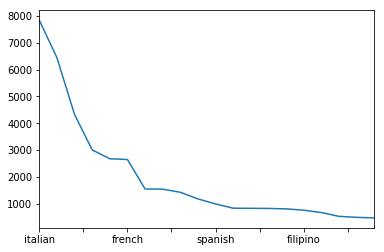

In [9]:
df.cuisine.value_counts().plot()

This dataset has a nice distripution of cuisines. The ingredient lists already has ingredient amounts removed.

## 2. Flatten Data
To make preprocessing easier, make a dataframe with one ingredient per row

In [31]:
#create the data frame
ingredients = pd.DataFrame({'cuisine': [], 'id': [], 'ingredient': []})

In [32]:
ingredients['id'] = ingredients['id'].astype(int) 
ingredients.dtypes

cuisine       float64
id              int64
ingredient    float64
dtype: object

In [34]:
#populate the dataframe
for i, row in df.iterrows():
    for item in row.ingredients:
        #append is slow; this would be faster building a dict first
        ingredients = ingredients.append({'cuisine': row.cuisine
                                          ,'id': row.id
                                          ,'ingredient': item},
                                         ignore_index=True)
    if i%1000 == 0:
       print (i, row.cuisine, row.ingredients)

ingredients.to_csv('ingredients.csv', index_label = False)
        

0 greek ['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']
1000 italian ['marinara sauce', 'goat cheese', 'minced garlic', 'salt', 'ground lamb', 'roasted red peppers', 'chopped onion', 'black pepper', 'refrigerated pizza dough', 'italian seasoning']
2000 filipino ['sea salt', 'annatto powder', 'cooking oil', 'beef broth', 'bok choy', 'chinese eggplants', 'peanut butter', 'onions', 'beef shank', 'garlic', 'green beans']
3000 greek ['olive oil', 'butter', 'dried oregano', 'chicken stock', 'bay leaves', 'garlic', 'salt and ground black pepper', 'red wine', 'chicken', 'tomato sauce', 'shallots', 'fresh parsley']
4000 indian ['water', 'flour', 'green chilies', 'nuts', 'curry leaves', 'milk', 'salt', 'ground cardamom', 'sweetener', 'buttermilk', 'oil', 'cumin', 'sugar', 'millet', 'cilantro leaves', 'ghee']
5000 moroccan ['mint sprigs', 'sugar', 'green tea']
6000 southern_us ['tomatoes', 'freshly gr

In [39]:
ingredients.shape

(428275, 3)

In [36]:
ingredients.head()

,cuisine,id,ingredient
0,greek,10259,romaine lettuce
1,greek,10259,black olives
2,greek,10259,grape tomatoes
3,greek,10259,garlic
4,greek,10259,pepper


## 3. Build a Standardized List of Ingredients 

In [232]:
ingredients.to_csv('ingredients_before_preprocess.csv', index_label = False)

Apply the preprocess function to each ingredient in the dataframe.

Then pull out the 1000 most common ingredients and save to a CSV.

Update the preprocess function based on visual inspection of the CSV,
to remove more extraneous terms.

Repeat until the we have reduced the ingredient list to almost all one and two word terms.


In [456]:
ingredients = pd.read_csv('ingredients_before_preprocess.csv')

In [457]:
ingredients.head()

,cuisine,id,ingredient
0,greek,10259,romaine lettuce
1,greek,10259,black olives
2,greek,10259,grape tomatoes
3,greek,10259,garlic
4,greek,10259,pepper


In [458]:
def preprocess (strng):
    #descriptive words that should be stripped out
    replace_list = ['peeled', 'fresh', 'ground', 'chopped', 'seeds', 'frozen',
                    'plain', 'light','heavy','dark', 'roasted', 'diced','cooked',
                    'pitted', 'canned', 'unsweeetened', 'sweetened', 'low',
                    'reduced','sodium','skim', 'part-skim', 'whole', 'low-fat',
                    'extra', 'extra-virgin','leaves', 'leaf', 'leaves','crumbles',
                    'powder','yellow', 'kosher', 'boneless', 'skinless', 'grilled',
                    'shredded', 'peeled', 'coarse', 'reduced', 'all-purpose', 'red',
                    'white', 'oven-ready', 'reduced-fat', 'thread', 'dried', 'dry',
                    'fat', 'free', 'finely', 'firmly', 'freshly', '1%', '2%', 'for',
                    'dusting', 'seasoned', 'sliced', 'slivered', 'soft', 'softened',
                    'small', 'toasted', 'unsweetened', 'pod', 'pods','cube','granule',
                    'floret','fine', 'baby', 'lower', 'lump', 'halves', 'lowfat',
                    'slices', 'all', 'purpose', 'unbleached', 'bone-in', 'granule',
                    'whole-milk', 'asian', 'sprigs', 'stem', 'cubes', 'granules', 'in',
                    'crumbled', 'crushed', 'blend', 'boneless', 'bottled', 'florets',
                    'california', 'chunky', 'flavored', 'cooking', 'baked', 'thai',
                    'store', 'bought', 'steamed', 'stewed', 'unsalted', 'unflavored',
                    'vietnamese', 'organic', 'cap', 'concentrate', 'packed', 'boiling',
                    'deveined', 'fat-free', 'self', 'rising', 'self-rising', 'instant',
                    'of', 'grated'
                   ]
    return_strng = ''
    strng = strng.lower()
    for w in strng.split():
        if w in replace_list:
            w = ''
        else:
            #remove pluralizations
            w = re.sub('oes$', 'o', w)
            w = re.sub('s$', '', w)           
        return_strng += w + ' '
        
    #remove formatting characters, and convert alternate spellings or
    #anomolous data to the a more common usage.
    return_strng = re.sub('"', '', return_strng)
    return_strng = re.sub(',', '', return_strng)
    return_strng = re.sub('chilie', 'chile', return_strng)
    return_strng = re.sub('chillie', 'chile', return_strng)
    return_strng = re.sub('yoghurt', 'yogurt', return_strng)
    return_strng = re.sub('won ton ', 'wonton', return_strng)
    return_strng = re.sub('whipping', 'whipped', return_strng)
    return_strng = re.sub('anchovie', 'anchovy', return_strng)
    return_strng = re.sub('artichok heart marin', 'artichoke heart', return_strng)
    return_strng = re.sub('colouring', 'coloring', return_strng)
    return_strng = re.sub('hellmann\' or best food real mayonnai', 'mayonaise', return_strng)
    return_strng = re.sub('mayonnaise', 'mayonaise', return_strng)
    return_strng = re.sub('wontonwrapper', 'wonton wrapper', return_strng)
    return_strng = re.sub('filet', 'fillet', return_strng) 
    return_strng = re.sub('-', ' ', return_strng) 
    return_strng = return_strng.strip()
    return_strng = re.sub('  ', ' ', return_strng)
    return(return_strng)

In [460]:
ingredients['ingredient2'] = ingredients['ingredient'].apply(preprocess)

In [461]:
ingredients.head()

,cuisine,id,ingredient,ingredient2
0,greek,10259,romaine lettuce,romaine lettuce
1,greek,10259,black olives,black olive
2,greek,10259,grape tomatoes,grape tomato
3,greek,10259,garlic,garlic
4,greek,10259,pepper,pepper


In [462]:
#check for records made null by preprocessing
ingredients[ingredients['ingredient2']==''].groupby('ingredient').count()

,cuisine,id,ingredient2
ingredient,,,
asian,1,1,1
chopped leaves,7,7,7
chunky,8,8,8
cooking fat,7,7,7
crumbles,11,11,11
extra,1,1,1
fat,92,92,92
florets,44,44,44
leaves,93,93,93


Since the original recipe ingredient in all of these cases was not very descriptive,
making all of these into nulls is ok.

In [463]:
#drop nulls, keep only preprocessed ingredients
ingredients.dropna(inplace=True)
ingredients.drop(['ingredient'], axis=1, inplace=True)
ingredients.rename(columns={'ingredient2':'ingredient'}, inplace=True) 

In [464]:
ingredients[ingredients['ingredient']==''].groupby('ingredient').count()  #why are there still nulls?

,cuisine,id
ingredient,,
,404,404


In [465]:
ingredients.head()

,cuisine,id,ingredient
0,greek,10259,romaine lettuce
1,greek,10259,black olive
2,greek,10259,grape tomato
3,greek,10259,garlic
4,greek,10259,pepper


In [466]:
#group all ingredients by cuisine
i2 = ingredients.groupby(['cuisine','ingredient']).count().reset_index()

In [467]:
i2.shape

(22110, 3)

In [468]:
i2.head()

,cuisine,ingredient,id
0,brazilian,,4
1,brazilian,acai juice,1
2,brazilian,active yeast,3
3,brazilian,adobo style seasoning,1
4,brazilian,agave nectar,4


In [469]:
#group all ingredients together
i3 = ingredients.groupby(['ingredient']).count().reset_index()
i3.drop(['id'], axis=1, inplace=True)
i3.rename(columns={'cuisine':'count'}, inplace=True) 

In [470]:
#save the top 1000 ingredients to csv
i3.sort_values('count', ascending=False).head(1000)[['count','ingredient']]\
.sort_values('ingredient').to_csv('ingredient_counts.csv',index_label = False)

The final version of ingredient_counts will be used as a custom vocabulary for vectorizing the data.